<font size = "4">
    <b>
        Coursere Capstone: where should Picnic deliver next?

Import required packages and determine settings

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geocoder 
import folium
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn import linear_model
import math
from sklearn.metrics import log_loss
pd.set_option('display.max_rows', 10)

<font size = "3"><b>  1) Business case

Picnic is a Dutch online supermarket. Ordering groceries online has become more popular over the past years: nowadays the amount of people doing online groceries has doubled compared to 2016 (https://www.trouw.nl/nieuws/online-boodschappen-doen-wint-aan-populariteit~b232e89d/?referrer=https%3A%2F%2Fwww.google.com%2F). A company anticipating on this trend is Picnic: the first supermarket that has no physical store anymore, but only distribution centers. For the company this is convenient because it requires e.g. less rent and less staff to pay. The groceries are delivered by small electric vehicles. In a world that becomes more aware of climate change, it is more convenient to have few electric vehicles driving around for delivering groceires, than that everyone has to drive to the supermarket by themselves. Furthermore, plastic bags and bottles can be returned every time groceries are delivered. For this reason, ordering groceries online is not only attractive for the eldery, but also for younger people.

The vehicles of Picnic are found in more and more cities throughout the Netherlands and the supermarket is very popular: there are huge waiting lists for people who want to become a customer, e.g. in Enschede, there are 20.000 people waiting (https://www.tubantia.nl/enschede/alweer-8-000-klanten-op-de-wachtlijst-enschede-is-een-echte-picnic-stad~afe3c277/?referrer=https%3A%2F%2Fwww.google.com%2F). Due to the popularity, a logical step is to to keep expanding to other cities. However, which city is most suitable to start delivering next? In which city can Picnic gain most profit? That is something to find out using data science.

<font size = "3">
        <b> 2)  Data

To find out where to make the most profit, it is required to determine factors that influence this. Unfortunately, Picnic does no provide data about their profits in certain regions of the Netherlands, but assumptions can be done on important factors. A multiple regression model can be constructed and it can be checked whether the predicted regions to make profit are indeed the regions where Picnic is already active or not. If this is true, from the model it can be determined what the next region can be.

The Dutch Central Statistical Office (https://www.cbs.nl/) provides many public data sets with information about e.g. population, income, house prices and more. This data base can provide useful parameters for a regression model, e.g. in regions where many people live or where people are wealthy, more profit can be made compared to poorer, less populated regions. 
Another indicator to determine if Picnic would be successful is the amount of grocery stores in a certain area. It is expected that Picnic would be more successful in regions where there are little grocery stores per 1.000 people compared to regions where there are many grocery stores per 1.000 people. For this reason, the Foursquare API can be used to determine the grocery store-density in certain regions.

It is also useful to know where Picnic is already delivering, first of all for validation of the model and secondly to be sure that in the conclusion it will no be recommended to start delivering in a region where Picnic is already active. This information is available on the website of Picnic (www.picnic.nl).

Unfortunately, data of the Central Statistical Office is based on municipalities, where the Picnic delivers in cities rather than in whole municipalities. To be able to do an analysis, the analysis will be performed based on municipitalities. For this reason, the city names from the website of Picnic are manually transformed to the municipalities where the cities are located in. 

The remainder of this section consists of preprocessing data to obtain the required data frames.

First, the data set containing population information in each municipality is loaded.

In [2]:
Population_municipalities = pd.read_csv('Data/Bevolking_gemeenten.csv',sep=';')        #Load data set containing population in municipities
df_pop_in_mun = pd.DataFrame(data=Population_municipalities)                           #Create dataframe from these data
df_pop_in_mun.columns = ['ID','Mun_code','Month','Start_month','End_month']            #Assign column names to this data set

C:\Users\KeizersLS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


For now, only the most actual population data is required. This is the data from the month that can be found in the last row of the data set. 
The data set is then recreated with only the population data of this last month.

In [3]:
Period_index = df_pop_in_mun[df_pop_in_mun['Month']==df_pop_in_mun['Month'].iloc[-1]].index            #Determine indices of rows to keep
df_pop_in_mun = df_pop_in_mun.loc[Period_index]                                                        #Only keep rows of last month
df_pop_in_mun.reset_index(drop=True,inplace=True)                                                      #Reset index
df_pop_in_mun.columns = ['ID','Mun_code','Month','Start_month','End_month']

From this data set, only the code of the municipality and the actual population data is required. Therefore, the columns containing the ID, month and data of the start of the month are removed. 
The first row contains the population of the whole Netherlands, which will also be removed as the interest is in the population of the municipities.

In [4]:
df_pop_in_mun = df_pop_in_mun.drop(['ID','Month','Start_month'],1)                                    #Remove not required columns


In [5]:
df_pop_in_mun = df_pop_in_mun[df_pop_in_mun['Mun_code'].str.startswith('GM', na=False)]

It should be noted that the data set also contains information about populations of provinces and the whole country. However, these will drop out later on when merging the data set with others, so these are kept for now.

Now a check is performed to see if the population data are integers.

In [6]:
df_pop_in_mun['End_month'].dtypes

dtype('O')

This is wrong! The data are first converted into integers.

In [7]:
df_pop_in_mun['End_month']= pd.to_numeric(df_pop_in_mun['End_month'],downcast="integer")
df_pop_in_mun['End_month'].dtypes

dtype('float64')

Now arrange the dataframe send in descending order. Then take a look at the dataframe.

In [8]:
df_pop_in_mun = df_pop_in_mun.sort_values(['End_month'],ascending=False)  #Sort by population
df_pop_in_mun.columns=['Mun_code','Population']                           #Rename column to population


There are NaN values in the dataframe. However, it is found that the codes that belong to the NaN values do not even exist in the Netherlands. This also explains why there are 551 rows in the data frame, while there are only 355 municipalities in the Netherlands. Therefore, the NaN rows are removed. Then a check is performed to see if the dimensions of the data frame are more logical.

In [9]:
df_pop_in_mun = df_pop_in_mun.dropna()
df_pop_in_mun.shape
df_pop_in_mun

,Mun_code,Population
78,GM0363,872445.0
450,GM0599,651524.0
223,GM0518,548165.0
515,GM0344,359374.0
189,GM0772,235465.0
...,...,...
499,GM0093,4893.0
74,GM0060,3766.0
452,GM0277,1709.0
534,GM0096,1208.0


This looks good. Now go to the next data set where the names of municipities are linked to the codes.

In [10]:
Mun_code_names = pd.read_csv('Data/Gemeente_namen_code.csv',sep=';')                                             # Read data
df_mun_code_names = pd.DataFrame(data=Mun_code_names)                                                            # Create data frame
df_mun_code_names.columns = ['Mun_code_num','Mun_code','Mun_name','County_code_num','County_code','County_name'] #Assign column names
df_mun_code_names.head()

,Mun_code_num,Mun_code,Mun_name,County_code_num,County_code,County_name
0,1680,GM1680,Aa en Hunze,22,PV22,Drenthe
1,358,GM0358,Aalsmeer,27,PV27,Noord-Holland
2,197,GM0197,Aalten,25,PV25,Gelderland
3,59,GM0059,Achtkarspelen,21,PV21,Friesland
4,482,GM0482,Alblasserdam,28,PV28,Zuid-Holland


The dimensions look right with 355 rows. Only the Municipality code- and name are of interest, so only these columns are kept.

In [11]:
df_mun_code_names = df_mun_code_names.drop(['Mun_code_num','County_code_num','County_code','County_name'],1)

Now the names can be added to the population dataframe by merging based on the municipality codes. Take a look to see if everything is fine.

In [12]:
df_pop = df_pop_in_mun.merge(df_mun_code_names,how='inner',on='Mun_code')
df_pop


,Mun_code,Population,Mun_name
0,GM0363,872445.0,Amsterdam
1,GM0599,651524.0,Rotterdam
2,GM0518,548165.0,'s-Gravenhage
3,GM0344,359374.0,Utrecht
4,GM0772,235465.0,Eindhoven
...,...,...,...
350,GM0093,4893.0,Terschelling
351,GM0060,3766.0,Ameland
352,GM0277,1709.0,Rozendaal
353,GM0096,1208.0,Vlieland


A distinguish can be made between municities where Picnic is already active and those where it is not. A vector is defined of cities where Picnic is already active. Unfortunately these data had to be put in manually.

In [13]:
Picnic_locations = ['Deventer', 'Hengelo', 'Enschede', 'Alkmaar', 'Amsterdam', 'Haarlemmermeer', 'Haarlem', 'Heemstede', 'Bloemendaal', 'Purmerend', 'Edam-Volendam', 'Waterland',
                                 'Velsen',  'Gooise Meren', 'Huizen', 'Laren', 'Blaricum', 'Hilversum',
                                'Gouda', 'Rotterdam', 'Delft', 'Rijswijk','Leidschendam-Voorburg','Pijnacker-Nootdorp','Midden-Delfland','Zoetermeer','Leiden','Den Haag','Nissewaard','Alphen aan den Rijn',
                    'Apeldoorn', 'Arnhem','Nijmegen','Ede','Venlo','Heerlen', 'Helmond','Tilburg','Breda','Eindhoven','\'s-Hertogenbosch','Nieuwegein','Zeist','Utrecht','Amersfoort','Almere',
                    'Zaanstad','Maastricht']


Let's see in which size municipities Picnic is already active.

In [14]:
Exist_vec = []
Not_exist_vec = []
Pop_vec = []
Ranking_vec = []

for i in range(len(df_pop)):
    if df_pop['Mun_name'][i] in Picnic_locations:
        Exist_vec.append(df_pop['Mun_name'][i])
        Pop_vec.append(df_pop['Population'][i])
        Ranking_vec.append(i+1)
        
    else:
        Not_exist_vec.append(df_pop['Mun_name'][i])
         
df_Existing = pd.DataFrame(data=[Exist_vec,Pop_vec,Ranking_vec]).transpose()            
df_Existing.columns = ['Mun_name','Residents in municipal','Ranking on population out of 354']
df_Existing.shape


(47, 3)

There is something wrong, because the vector that is created is missing one location. Let's find out which one.

In [15]:
for mun in Picnic_locations:
    if mun in np.array(df_Existing['Mun_name']):
        continue
    else: 
        print(mun + ' is not in list!')
    

Den Haag is not in list!


Den Haag is known as 's Gravenhage as well. Let's see if it that might be the problem.

In [16]:
'\'s-Gravenhage' in np.array(df_pop['Mun_name'])

True

In [17]:
df_pop = df_pop.replace('\'s-Gravenhage','Den Haag')

In [18]:
Exist_vec = []
Not_exist_vec = []
Pop_vec = []
Ranking_vec = []

for i in range(len(df_pop)):
    if df_pop['Mun_name'][i] in Picnic_locations:
        Exist_vec.append(df_pop['Mun_name'][i])
        Pop_vec.append(df_pop['Population'][i])
        Ranking_vec.append(i+1)
        
    else:
        Not_exist_vec.append(df_pop['Mun_name'][i])
         
df_Existing = pd.DataFrame(data=[Exist_vec,Pop_vec,Ranking_vec]).transpose()            
df_Existing.columns = ['Mun_name','Residents in municipal','Ranking on population out of 354']
df_Existing.shape

(48, 3)

That's fine. Let's take a look at the dataframe of existing locations.

In [19]:
df_Existing.head(18)
    

,Mun_name,Residents in municipal,Ranking on population out of 354
0,Amsterdam,872445,1
1,Rotterdam,651524,2
2,Den Haag,548165,3
3,Utrecht,359374,4
4,Eindhoven,235465,5
...,...,...,...
13,Amersfoort,157691,15
14,Haarlemmermeer,157440,16
15,Zaanstad,157073,17
16,'s-Hertogenbosch,155586,18


In [20]:
df_Existing.shape

(48, 3)

It is found that Pinnic is already active in most of the larger cities. However, there are some gaps here. On the other hand, there are some very small municipities where they are already active. So, there are more reasons to select certain locations for delivering groceries. The municipties at the end of the list are well-known in the Netherlands due to the rich people living over there, so it might be interesting to have an insight in how rich a certain area is. Because data sets about income were not found to be complete, a data set containing information about house prices is selected. A check is performed to see if the house price is of the right type (float).

In [21]:
Houseprices = pd.read_csv('Data/Huizenprijzen.csv',sep=';',header=0)   #Read data
df_house_prices = pd.DataFrame(data=Houseprices)                       #Create data frame
df_house_prices.columns=['Mun_name','Average House Price']             #Assign column names
df_house_prices = df_house_prices.replace('s-Hertogenbosch','\'s-Hertogenbosch')
df_house_prices['Average House Price'].dtype                           #Check data type


dtype('float64')

In [22]:
for mun in df_pop['Mun_name']:
    if mun in np.array(df_house_prices['Mun_name']):
        continue
    else:
        print(mun + ' is not in list!')

Súdwest-Fryslân is not in list!
Noardeast-Fryslân is not in list!
Nuenen, Gerwen en Nederwetten is not in list!
Valkenburg aan de Geul is not in list!


After taking a look at the data set the names are changed such that they are similar to the other data sets:

In [23]:
df_house_prices.replace('Valkenburg a/d Geul','Valkenburg aan de Geul',inplace=True)
df_house_prices.replace('SÃºdwest FryslÃ¢n','Súdwest-Fryslân',inplace=True)
df_house_prices.replace('Noardeast-FryslÃ¢n','Noardeast-Fryslân',inplace=True)
df_house_prices.replace('Nuenen','Nuenen, Gerwen en Nederwetten',inplace=True)
df_house_prices.shape
df_house_prices

,Mun_name,Average House Price
0,Appingedam,194.8
1,Delfzijl,155.1
2,Groningen,258.9
3,Loppersum,192.4
4,Almere,294.3
...,...,...
350,Hoeksche Waard,297.3
351,Het Hogeland,188.8
352,Westerkwartier,240.8
353,Noardeast-Fryslân,194.8


That looks good. Now add the data to the existing data set with the population.

In [24]:
df_Existing = df_Existing.merge(df_house_prices,how='inner',on='Mun_name')
df_Existing.shape


(48, 4)

In [25]:
for mun in Picnic_locations:
    if mun in np.array(df_Existing['Mun_name']):
        continue
    else: 
        print(mun + ' is not in list!')

        

It is found that in the house prices data set some of the names have additions to indicate e.g. the province or to indicate that it is about the municipality and not the city (for cities with similar names as the municipality). This should be changed.

In [26]:
for mun in df_house_prices['Mun_name']:
    if 'bosch' in mun:
        print(mun)

's-Hertogenbosch


In [27]:
for mun in Picnic_locations:
    if 'bosch' in mun:
        print(mun)

's-Hertogenbosch


In [28]:
#np.mean(df_Existing['Average House Price'])
print(np.mean(df_Existing['Average House Price'].head(5)))
print(np.mean(df_Existing['Average House Price'].tail(5)))

356.26
639.88


This indicates that Picnic would like to operate at locations where many, or where rich people live. However, first take a closer look at the tail of the existing location dataframe. Another interesting feature is the grocery store density in the municipality. FourSquare API will be used to find the grocery store density in each municipality of the Netherlands. 

In [29]:
def get_latlng(mun):
    lat_lng_coords = None
    
    while (lat_lng_coords is None):
        g = geocoder.arcgis('{},Netherlands'.format(mun))
        lat_lng_coords = g.latlng
        return lat_lng_coords

In [30]:
# df_coords = pd.DataFrame(data=(),columns=['Mun_name','lat','lon'])
# for mun in df_pop['Mun_name']:
#     coords = get_latlng(mun)
#     df_coords = df_coords.append({
#         'Mun_name': mun,
#         'lat'     : coords[0],
#         'lon'     : coords[1]
#     },ignore_index = True)


In [31]:
#df_coords.to_csv('df_coords_csv')
df_coords = pd.read_csv('df_coords_csv',index_col = 0)

Because computing all grocery stores in a municipality will be hard (the radius of a municipality varies) and very computationally expensive, the search radius will be set to 1km and it is expected that this will be a proper indication for the amount of grocery stores in the 

In [32]:
# radius = 500
# CLIENT_ID = 'HGZYW40JN0VBQLR4DHP5CPJNKMA5UCFRP5MXTZYYMLC15BBX' # your Foursquare ID
# CLIENT_SECRET = 'Q251IPA2DD5VMNMIN0RGSFPRIQ550GL0KVHE4VIPLLENF3GE' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version
# LIMIT = 100 # A default Foursquare API limit value
# CatId = '4bf58dd8d48988d118951735'

In [33]:
# def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
#     venues_list=[]
#     for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
#         # create the API request URL
#         url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
#             CLIENT_ID, 
#             CLIENT_SECRET, 
#             VERSION, 
#             lat, 
#             lng, 
#             radius, 
#             LIMIT,
#             CatId)
            
#         # make the GET request
#         results = requests.get(url).json()["response"]['groups'][0]['items']
        
#         # return only relevant information for each nearby venue
#         venues_list.append([(
#             name, 
#             lat, 
#             lng, 
#             v['venue']['name'], 
#             v['venue']['location']['lat'], 
#             v['venue']['location']['lng'],  
#             v['venue']['categories'][0]['name']) for v in results])

#     nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
#     nearby_venues.columns = ['Mun_name', 
#                   'Mun_Latitude', 
#                   'Mun_Lon', 
#                   'Venue', 
#                   'Venue Latitude', 
#                   'Venue Longitude', 
#                   'Venue Category']
    
#     return(nearby_venues)

In [34]:
map = folium.Map(location=[52.096298, 5.450912], zoom_start=7.3)

for lat, lon in zip(df_coords['lat'], df_coords['lon']):
    folium.Circle(
    [lat, lon],
    radius=5000,
    #popup=label,
    fill=True,
    #fill_color=rainbow[int(cluster)-1],
    fill_opacity=0.7).add_to(map)
map


In [35]:
#Grocery_venues = getNearbyVenues(df_coords['Mun_name'],latitudes=df_coords['lat'],longitudes=df_coords['lon'])

To avoid making new calls, the dataframe is saved and is opened from a file:

In [36]:
#Grocery_venues.to_csv('Grocery_stores_csv')
Grocery_venues = pd.read_csv('Grocery_stores_csv',index_col = 0)

In [37]:
Grocery_venues

,Mun_name,Mun_Latitude,Mun_Lon,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amsterdam,52.36993,4.90788,SPAR city Korstanje,52.370554,4.910020,Convenience Store
1,Amsterdam,52.36993,4.90788,Albert Heijn,52.368762,4.903477,Grocery Store
2,Amsterdam,52.36993,4.90788,SPAR city Van Kempen,52.366537,4.906142,Convenience Store
3,Rotterdam,51.91438,4.48716,SPAR city Glashaven,51.916405,4.485656,Convenience Store
4,Den Haag,52.08409,4.31732,SPAR Den Haag Centraal,52.081856,4.321592,Grocery Store
...,...,...,...,...,...,...,...
356,Eemnes,52.25336,5.25860,Lekker Gezond Groente En Fruit,52.252966,5.264246,Grocery Store
357,Terschelling,53.35839,5.21635,SPAR Berghuis West Terschelling,53.360309,5.215170,Convenience Store
358,Ameland,53.44296,5.68673,SPAR Manje,53.445197,5.686481,Convenience Store
359,Schiermonnikoog,53.47723,6.16121,SPAR Brunekreef Schiermonnikoog,53.478417,6.160780,Convenience Store


Duplicates are found, e.g. the SPAR in Schiermonnikoog is displayed twice. Duplicates should be removed, but this should not be done on the venue name, because there are e.g. multiple 'Albert Heijns'. The coordinates are rounded on three decimals and duplicates based on these coordinates are removed from the data frame.

In [38]:
Lat_round = pd.DataFrame(round(Grocery_venues['Venue Latitude'],3))
Lon_round = pd.DataFrame(round(Grocery_venues['Venue Longitude'],3))
Grocery_venues['Venue Latitude'] = Lat_round
Grocery_venues['Venue Longitude'] = Lon_round
Grocery_venues_fin = Grocery_venues.drop_duplicates(['Venue Latitude','Venue Longitude'])

Now the number of grocery stores are counted.

In [39]:
Num_of_Stores = Grocery_venues_fin['Mun_name'].value_counts()

In [40]:
df_Num_of_Stores = pd.DataFrame(Num_of_Stores,index=None)
df_Num_of_Stores = df_Num_of_Stores.reset_index()

In [41]:
df_Num_of_Stores.columns = ['Mun_name','Count']

In [42]:
df_Num_of_Stores

,Mun_name,Count
0,Venlo,6
1,De Bilt,5
2,Alkmaar,5
3,Purmerend,5
4,Castricum,4
...,...,...
201,Borne,1
202,Den Helder,1
203,Westervoort,1
204,Soest,1


From this information, a feature will be derived and added to the dataframe:

In [43]:
df_pop_stores_prices = []

df_counted = df_pop.merge(df_Num_of_Stores,how='outer',on='Mun_name')               # Count grocery stores
df_counted = df_counted.fillna(0)                                                   # Fill NaN values with 0

df_pop_stores_prices=[]                                                             # Create new dataframe
df_pop_stores_prices = df_counted.merge(df_house_prices,how='inner',on='Mun_name')  # Merge house prices, numbers of stores and population

Check if data frame is as expected

In [44]:
df_pop_stores_prices.head(5)

,Mun_code,Population,Mun_name,Count,Average House Price
0,GM0363,872445.0,Amsterdam,3.0,485.0
1,GM0599,651524.0,Rotterdam,1.0,282.9
2,GM0518,548165.0,Den Haag,3.0,324.8
3,GM0344,359374.0,Utrecht,4.0,379.8
4,GM0772,235465.0,Eindhoven,2.0,308.8


Create new feature: Number of stores / Stores found by Foursquare API

In [45]:
pop_per_store = df_pop_stores_prices['Count']/df_pop_stores_prices['Population']

Add new feature to dataframe and check if data frame is as expected

In [46]:
df_pop_stores_prices.insert(5,"Population per store",pop_per_store,True)
df_pop_stores_prices.head(10)

,Mun_code,Population,Mun_name,Count,Average House Price,Population per store
0,GM0363,872445.0,Amsterdam,3.0,485.0,0.000003
1,GM0599,651524.0,Rotterdam,1.0,282.9,0.000002
2,GM0518,548165.0,Den Haag,3.0,324.8,0.000005
3,GM0344,359374.0,Utrecht,4.0,379.8,0.000011
4,GM0772,235465.0,Eindhoven,2.0,308.8,0.000008
5,GM0014,233266.0,Groningen,2.0,258.9,0.000009
6,GM0855,220589.0,Tilburg,1.0,265.3,0.000005
7,GM0034,214133.0,Almere,2.0,294.3,0.000009
8,GM0758,184306.0,Breda,0.0,350.0,0.000000
9,GM0268,177525.0,Nijmegen,0.0,293.8,0.000000


<font size = "3">
<b> 3) Methodology 

Because there is no information available about the profit in the municipities where Picnic is already active, it is a binary problem: the model should be trained on information whether Picnic is already active or not. An additional column will be added to the dataframe with all features indicating whether Picnic is already active (1) or not (0). The features will be normalize and the data frame will be splitted in in a training- and test data set. Then the logistic regression model predicts based on the features of each municipality if Picnic is active in the municipality. The Jaccard score gives insight in the quality of the model.

However, the aim of the project is to find out which new municipities might be interesting for Picnic. For this reason, for each municipality, the probability that Picnic is already active will be determined. If the probability for a municipality is high, while Picnic is not active, this is an interesting area for further expansion of the company. The log_loss metric indicates the quality of the predictions.

Thereafter the results of the models and the quality of the models will be discussed and it will be discussed how to further improve the model.

<font size = "3">

<b> 4) Results <br>
  
   

<font size = "2">

<b> 4.1) Logistic Regression (binary) <br>

First of all, a is created which indicates wheter Picnic is already active in the municipality or not.

In [47]:
Exist_vec = []                                          #Create new vector
for mun in df_pop_stores_prices['Mun_name']:            #If Picnic already active, add 1. Else 0.
    if mun in np.array(df_Existing['Mun_name']):
        Exist_vec.append(1)
    else:
        Exist_vec.append(0)
        

Then the vector is added to the data frame and a check is performed to see if the data frame is as expected.

In [48]:
df_pop_stores_prices.insert(6,"Existing",Exist_vec,True)  #Add vector with binary values to dataframe
df_pop_stores_prices.head()

,Mun_code,Population,Mun_name,Count,Average House Price,Population per store,Existing
0,GM0363,872445.0,Amsterdam,3.0,485.0,0.000003,1
1,GM0599,651524.0,Rotterdam,1.0,282.9,0.000002,1
2,GM0518,548165.0,Den Haag,3.0,324.8,0.000005,1
3,GM0344,359374.0,Utrecht,4.0,379.8,0.000011,1
4,GM0772,235465.0,Eindhoven,2.0,308.8,0.000008,1


This looks good. Now create a vector with the features (X) and with the output vector (Y).

In [49]:
X = np.asarray(df_pop_stores_prices[['Population','Average House Price','Count','Population per store']])  #The features
Y = np.asarray(df_pop_stores_prices[['Existing']])                                                        #Picnic is or is not active

Before creating the logistic regression model, the features are normalized.

In [50]:
X = preprocessing.StandardScaler().fit(X).transform(X)                                                    #Normalize data

Then the data are split in a training- and test data set. This will result in a trainig data set of 266 municipities and a test data set of 89 municipities.

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (266, 4) (266, 1)
Test set: (89, 4) (89, 1)


Now the logistic regression model is created.

In [52]:
LR = LogisticRegression(C=1, solver='liblinear').fit(X_train,Y_train)    #Create logistic regression model

C:\Users\KeizersLS\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [53]:
b0 = LR.coef_[0][0]
b1 = LR.coef_[0][1]
b2 = LR.coef_[0][2]
b3 = LR.coef_[0][3]

The coefficients of the logistic regression model indicate the influence of certain features on the classification:

In [54]:
print('Coefficient population: ' + str(b0))
print('Coefficient house prices: ' +str(b1))
print('Absolute value number of grocery stores in radius ' + str(b2))
print('Coefficient population per grocery store in radius ' + str(b3)
     )

Coefficient population: 2.286340717900021
Coefficient house prices: 0.809027983209391
Absolute value number of grocery stores in radius 0.7402370041278474
Coefficient population per grocery store in radius -1.0343335134627842


So the population, house price and amount of grocery stores contribute to a higher probability of success and the population per grocery store has a negative influence on the probability. 

Using the logistic regression model, the outcome of the test data set is predicted.

In [55]:
yhat = LR.predict(X_test)                                                 #Predict values


To see how the model is able to indicate existing Picnic locations as good potential locations, the Jaccard Similarity Score is calculated:

In [56]:
jaccard_score(Y_test, yhat)

0.5833333333333334

This is not very good. A confusion matrix will be constructed to evaluate the output.

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(Y_test, yhat, labels=[1,0]))

[[ 7  4]
 [ 1 77]]


Confusion matrix, without normalization
[[ 7  4]
 [ 1 77]]


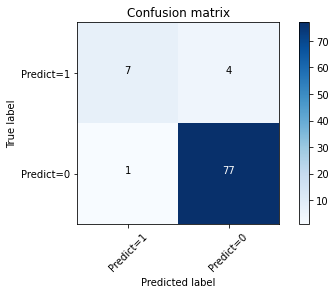

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Predict=1','Predict=0'],normalize= False,  title='Confusion matrix')

From the eleven locations where Picnic is already active, 7 out of the 11 are considered as good locations. However, there are also 4 municipities classified as municipities where Picnic is not already active. A possible reason for this misclassification will be discussed in the discussion section.

<font size = "2">


<b> 4.2) Logistic regression (probability)

The logistic regression classifies the municipities in 0 or 1. If 1, the municipality is similar to the municipities where Picnic is already active and if 0, not. But most of the most profitable municipities are already occupied by Picnic and therefore the look is for the municipities which thereafter will gain most profit. E.g. in the confusion matrix, the one municipality that is predicted that Picnic is active there, but where it is not, it interesting for future expanding of the company. To find out which municipities have potential, the probabilities that a municipality belongs to class 1 are determined.

In [59]:
yhat_proba = LR.predict_proba(X_test)

The log_loss metric indicates how qualitative the model is.

In [60]:
yhat_proba_score = log_loss(Y_test, yhat_proba)
yhat_proba_score

0.16198766880889562

The score of the model is poor. To find out what to do to improve the model, the probabilities are plotted for the complete data set. 

In [61]:
yhat_proba_tot = LR.predict_proba(X)

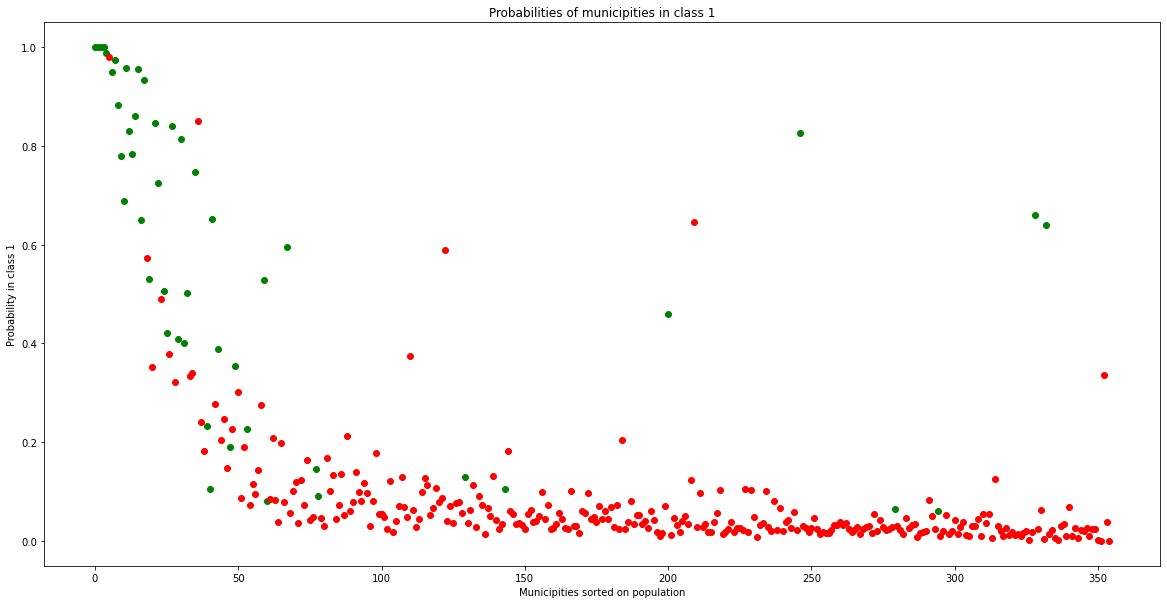

In [62]:
fig = plt.figure(figsize=(20,10))
plt.ylabel('Probability in class 1')  
plt.xlabel('Municipities sorted on population')
plt.title('Probabilities of municipities in class 1')
#plt.ylabel('Probability class 1')

for i in range(len(df_pop_stores_prices['Mun_name'])):
    if df_pop_stores_prices['Mun_name'][i] in np.array(df_Existing['Mun_name']):
        plt.plot(i,yhat_proba_tot[i][1],'go')
    else:
         plt.plot(i,yhat_proba_tot[i][1],'ro')
        


The municipites are sorted on population, so the data points at the left are larger municipities and many of municipities where Picnic is active, are located at the left side of the spectrum. However, some high probabilities are found at the right. To evaluate which municipities these are, the data set is again divided in active- and non-active municipities. First, the probabilities are added to the data frame.

In [63]:
df_pop_stores_prices.insert(7,"Predicted proba",yhat_proba_tot[:,1],True)

Now the data frame is divided using the 'Existing' column indicating wheter Picnic is already active or not.

In [64]:
df_Active = df_pop_stores_prices.loc[df_pop_stores_prices['Existing'] == 1]
df_Not_active = df_pop_stores_prices.loc[df_pop_stores_prices['Existing'] == 0]

Now a look is taken at the smallest municipities in the data frame where Picnic is already active.

In [65]:
df_Active.tail(10)

,Mun_code,Population,Mun_name,Count,Average House Price,Population per store,Existing,Predicted proba
77,GM1926,55441.0,Pijnacker-Nootdorp,0.0,375.9,0.000000,1,0.145476
78,GM0603,55096.0,Rijswijk,1.0,280.8,0.000018,1,0.090552
129,GM0406,41139.0,Huizen,0.0,408.5,0.000000,1,0.129256
143,GM0385,36220.0,Edam-Volendam,3.0,326.3,0.000083,1,0.104878
200,GM0397,27459.0,Heemstede,1.0,626.6,0.000036,1,0.458526
246,GM0377,23568.0,Bloemendaal,0.0,831.6,0.000000,1,0.826514
279,GM1842,19389.0,Midden-Delfland,0.0,399.6,0.000000,1,0.064697
294,GM0852,17374.0,Waterland,1.0,424.2,0.000058,1,0.061416
328,GM0376,11863.0,Blaricum,0.0,775.9,0.000000,1,0.660784
332,GM0417,11379.0,Laren,0.0,768.1,0.000000,1,0.640519


It is found that the house prices in some of these regions are very high and the amounts of grocery stores is low. This explains why although the population is small, these municipities are interesting. However, other municipities in this list are small, do no have high house prices and not few grocery stores. The locations of these municipities are plotted on a map of the Netherlands to see where they the municipities are located. First the, municities are sorted by their probability value.

In [66]:
df_Active = df_Active.sort_values('Predicted proba',ascending=False)

df_Active

,Mun_code,Population,Mun_name,Count,Average House Price,Population per store,Existing,Predicted proba
0,GM0363,872445.0,Amsterdam,3.0,485.0,0.000003,1,1.000000
1,GM0599,651524.0,Rotterdam,1.0,282.9,0.000002,1,1.000000
2,GM0518,548165.0,Den Haag,3.0,324.8,0.000005,1,1.000000
3,GM0344,359374.0,Utrecht,4.0,379.8,0.000011,1,0.999963
4,GM0772,235465.0,Eindhoven,2.0,308.8,0.000008,1,0.987798
...,...,...,...,...,...,...,...,...
40,GM1930,85315.0,Nissewaard,0.0,237.8,0.000000,1,0.104423
78,GM0603,55096.0,Rijswijk,1.0,280.8,0.000018,1,0.090552
60,GM0356,63748.0,Nieuwegein,0.0,278.3,0.000000,1,0.080331
279,GM1842,19389.0,Midden-Delfland,0.0,399.6,0.000000,1,0.064697


To plot the high probability municipities in a different color the high probability municipities, the data set is split in two data frames.

In [67]:
df_coords_active_tail = pd.DataFrame(data=(),columns=['Mun_name','lat','lon'])
df_coords_active_head = pd.DataFrame(data=(),columns=['Mun_name','lat','lon'])

Now the coordinates of both data frames are determined and the municipities are plotted on the map.

In [68]:
for mun in df_Active['Mun_name'].tail(24):
    coords = get_latlng(mun)
    df_coords_active_tail = df_coords_active_tail.append({
         'Mun_name': mun,
         'lat'     : coords[0],
         'lon'     : coords[1]
     },ignore_index = True)
    
for mun in df_Active['Mun_name'].head(24):
    coords = get_latlng(mun)
    df_coords_active_head = df_coords_active_head.append({
         'Mun_name': mun,
         'lat'     : coords[0],
         'lon'     : coords[1]
     },ignore_index = True)    

In [69]:
map = folium.Map(location=[52.096298, 5.450912], zoom_start=7.3)

for lat, lon in zip(df_coords_active_tail['lat'], df_coords_active_tail['lon']):
    folium.Circle(
    [lat, lon],
    radius=3000,
    #popup=label,
    fill=True,
    fill_color='#F8350B',
    fill_opacity=0.7).add_to(map)
    
for lat, lon in zip(df_coords_active_head['lat'], df_coords_active_head['lon']):
    folium.Circle(
    [lat, lon],
    radius=3000,
    #popup=label,
    fill=True,
    fill_color='#0BF824',
    fill_opacity=0.7).add_to(map)
map

This map shows that many of the municipities are relatively close to each other. What to do with this information, will be discussed further in the discussion section. Now first it will be determined where Picnic should start delivering next, based on this logistic regression model.




In [70]:
df_Not_active = df_Not_active.sort_values('Predicted proba',ascending=False)
df_Not_active.reset_index()

,index,Mun_code,Population,Mun_name,Count,Average House Price,Population per store,Existing,Predicted proba
0,5,GM0014,233266.0,Groningen,2.0,258.9,0.000009,0,9.791669e-01
1,36,GM0362,91061.0,Amstelveen,2.0,525.2,0.000022,0,8.498615e-01
2,209,GM0629,26681.0,Wassenaar,1.0,711.3,0.000037,0,6.450573e-01
3,122,GM0310,43328.0,De Bilt,5.0,481.4,0.000115,0,5.895832e-01
4,18,GM0193,129465.0,Zwolle,1.0,293.1,0.000008,0,5.723832e-01
...,...,...,...,...,...,...,...,...,...
302,326,GM0765,12155.0,Pekela,1.0,161.3,0.000082,0,3.127557e-03
303,336,GM0965,10517.0,Simpelveld,2.0,227.4,0.000190,0,2.055613e-03
304,350,GM0093,4893.0,Terschelling,1.0,327.5,0.000204,0,1.863941e-03
305,351,GM0060,3766.0,Ameland,1.0,321.2,0.000266,0,6.650821e-04


This shows that Groningen should be the next step. Thereafter, Amstelveen is lsited, which is relatively large and has relatively high house prices. Wassenaar is listed third, which is small, but a very wealthy population.

<b><font size = "3">

<b> 5) Discussion 

The metrics of the logistic regression model are, unfortunately, poor. Therefore, it is good to discuss how to improve the model. 

<font size = "2">
    <b>
        5.1) Municipality - City level

First of all, because the Dutch Statistical Office provides data on municipality level rather than on city-level, the analysis is performed on municipality level. However, a municipality can consist of multiple cities from which one can be attractive for Picnic and the other is not. Furthermore, the coordinates to look for the amount of grocery stores per population can be picked in an area in a municipality where no city center is located, and because only in a certain radius grocery stores are searched using FourSquare, this can give a false representation of the grocery store density in the cities in the municipality. 

For this reason, it would be interesting to have knowledge available on city-level rather than on municipality-level for more accurate prediction models.

<font size = "2">
<b> 5.2) Feature selection

Only a few features are selected: population, estimated amount of grocery stores in a radius in the municipality, grocery stores per population and house prices. However, possibly there are more factors playing a role in selecting new cities to start delivering. During this assignment, it was found that a similar analysis is performed by a professional company as well to look for potential for Picnic, where also features as family size and age were considered (https://media.prdn.nl/retailtrends/files/Groeipotentie%20online%20boodschappen.pdf). From this analysis however, it was found that income is a very good feature. 

However, also the distance to already existing distribution centers or active areas can play a role in the selection of new areas. For example, it is found that Picnic is active in almost all large cities in the Netherlands, except for the number 5 city, which is Groningen, and which is located far from the current active area of Picnic. And when looking at the map indicating where Picnic is already active, it is found that some munipities with relatively low probabilities are close to existing areas. So distance to active areas can be a good feature to improve the model.

<font size = "2">
<b> 5.3) Clustering

Some of the municipalities where Picnic is already active have a very low probability value from the model. However, when looking at the map of the Netherlands indicating where Picnic is already active, it is found that multiple red spots (lower probability areas) are near the high probability areas. If multiple small municipalities are very close to each other, together they form a higher populated cluster, so it can be interesting to not look at individual municipalities, but cluster municipalities- or cities that are close to each other together. 



<font size = "2">
<b> 5.4) Multiple Linear regression

Because no data was available about the profits of Picnic in certain areas, this analysis is limited to a classification model. However, if there is data available about the earnings of Picnic in already active areas, a multiple linear regression model can be build to predict the earnings in new areas. A training- and test data set can be constructed of already active areas to determine the accuracy of the profit predictions and if the model performs well, predictions can be done on the unknown areas. This can lead to better insights than only a classification model.

<font size = "4">
<b> 6) Conclusion

Data analysis can be a powerful  tool to predict where regions are with a high market potential. In this analysis, a logistic regression model is created to predict where Picnic should start delivering groceries. Unfortunately, the model did not perform very well. To improve the model, it would be interesting to start looking at city-level, to investigate additional features and to start clustering cities or municipities. In a real scenario, it would be useful to have information about the earnings in active areas to be able to predict the market potential in new areas.

